# Performance Efficiency Analysis: Shot Creation in Football

This analysis focuses on evaluating player performance efficiency using the following dataset columns:
- **SCA90**: Shot creation actions per 90 minutes
- **TO**: Take-ons for shot creation
- **Age**: Player age
- **Pos**: Player position

We will:
- Calculate take-on dependency ratios (TO/SCA) and SCA90 rankings
- Visualize SCA90 vs take-on dependency (scatter plot, colored by position, sized by age)
- Perform correlation analysis between SCA90, take-on rates, age, and position
- Identify the top 20 most efficient players using a composite efficiency score
- Summarize statistics by position and test for significance in creation efficiency differences
- Present interactive plots and tables for insights


In [435]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, kruskal
from sklearn.preprocessing import LabelEncoder
from numpy.polynomial.polynomial import Polynomial
from sklearn.metrics import r2_score

In [436]:
# Load dataset
shot_df = pd.read_csv('Shot_Creation.csv')

# Preview relevant columns
shot_df[['Player', 'Pos', 'Age', 'SCA', 'SCA90', 'TO']].head()

,Player,Pos,Age,SCA,SCA90,TO
0,Mohamed Salah,FW,32-342,164,4.50,22
1,Virgil van Dijk,DF,33-319,48,1.33,1
2,Ryan Gravenberch,MF,23-007,66,1.92,5
3,Alexis Mac Allister,MF,26-150,120,4.15,2
4,Ibrahima Konaté,DF,25-363,31,1.12,0


In [437]:
# Clean and convert columns
shot_df['SCA'] = pd.to_numeric(shot_df['SCA'], errors='coerce')
shot_df['SCA90'] = pd.to_numeric(shot_df['SCA90'], errors='coerce')
shot_df['TO'] = pd.to_numeric(shot_df['TO'], errors='coerce')
shot_df['Age'] = shot_df['Age'].str.extract(r'(\d{2})').astype(float)

# Calculate take-on dependency ratio
shot_df['TO_SCA_ratio'] = shot_df['TO'] / shot_df['SCA']

# SCA90 ranking
shot_df['SCA90_rank'] = shot_df['SCA90'].rank(ascending=False, method='min')

# Drop rows with missing values in key columns
shot_df = shot_df.dropna(subset=['SCA', 'SCA90', 'TO', 'TO_SCA_ratio', 'Age'])

# Remove 'Squad Total' and 'Opponent Total' rows from the data
shot_df = shot_df[~shot_df['Player'].str.contains('Squad Total|Opponent Total', case=False, na=False)]

# Filter out players with very low SCA or SCA90 to reduce plot crowding
min_sca = 20  # Increase threshold
min_sca90 = 4.0  # Increase threshold
shot_df = shot_df[(shot_df['SCA'] >= min_sca) & (shot_df['SCA90'] >= min_sca90)]

# Preview new columns
shot_df[['Player', 'Pos', 'Age', 'SCA', 'SCA90', 'TO', 'TO_SCA_ratio', 'SCA90_rank']].head()

,Player,Pos,Age,SCA,SCA90,TO,TO_SCA_ratio,SCA90_rank
0,Mohamed Salah,FW,32.0,164,4.50,22,0.134146,90.0
3,Alexis Mac Allister,MF,26.0,120,4.15,2,0.016667,103.0
5,Dominik Szoboszlai,MF,24.0,117,4.33,5,0.042735,97.0
9,Luis Díaz,FW,28.0,117,4.52,16,0.136752,88.0
19,Harvey Elliott,"MF,FW",22.0,21,5.18,1,0.047619,68.0


In [438]:
# Interactive scatter plot: SCA90 vs Take-on Dependency
fig = px.scatter(
    shot_df,
    x='TO_SCA_ratio',
    y='SCA90',
    color='Pos',
    size='Age',
    hover_data=['Player', 'SCA', 'TO', 'SCA90', 'TO_SCA_ratio', 'Age', 'Pos'],
    labels={'TO_SCA_ratio': 'Take-on Dependency Ratio (TO/SCA)', 'SCA90': 'SCA per 90'},
    title='SCA90 vs Take-on Dependency Ratio by Position and Age',
    height=600
)
fig.show()

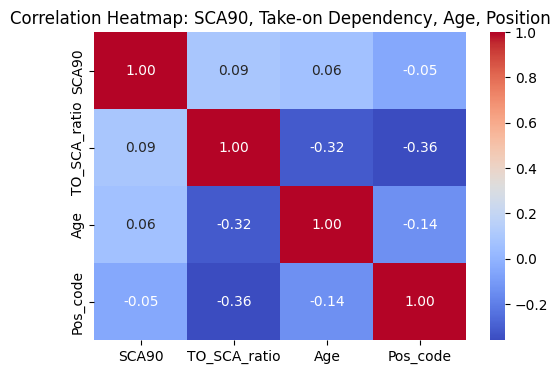

In [439]:
# Correlation analysis between SCA90, TO_SCA_ratio, Age, and position (encoded numerically)
corr_df = shot_df.copy()
corr_df['Pos_code'] = LabelEncoder().fit_transform(corr_df['Pos'])
corr = corr_df[['SCA90', 'TO_SCA_ratio', 'Age', 'Pos_code']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: SCA90, Take-on Dependency, Age, Position')
plt.show()

In [440]:
# Composite efficiency score: high SCA90, low TO_SCA_ratio, and diversity (1-TO_SCA_ratio)
shot_df['efficiency_score'] = (
    (shot_df['SCA90'] / shot_df['SCA90'].max()) * 0.6 +
    ((1 - shot_df['TO_SCA_ratio']) / (1 - shot_df['TO_SCA_ratio']).max()) * 0.4
)
# Rank by efficiency
shot_df['efficiency_rank'] = shot_df['efficiency_score'].rank(ascending=False, method='min')

top20 = shot_df.nsmallest(20, 'efficiency_rank')[['Player', 'Pos', 'Age', 'SCA90', 'TO_SCA_ratio', 'efficiency_score', 'efficiency_rank']]
display(top20)

,Player,Pos,Age,SCA90,TO_SCA_ratio,efficiency_score,efficiency_rank
64,Kevin De Bruyne,"MF,FW",33.0,5.99,0.026549,0.989381,1.0
72,Jack Grealish,"FW,MF",29.0,5.86,0.063830,0.961446,2.0
36,Bukayo Saka,"FW,MF",23.0,5.93,0.098214,0.954704,3.0
111,Cole Palmer,MF,23.0,5.81,0.080000,0.949970,4.0
441,Bruno Fernandes,MF,30.0,5.56,0.027624,0.945878,5.0
277,Reiss Nelson,FW,25.0,5.73,0.096774,0.935247,6.0
62,Sávio,"FW,MF",21.0,5.71,0.135135,0.917899,7.0
162,Marcus Rashford,FW,27.0,5.49,0.111111,0.905472,8.0
279,Tom Cairney,MF,34.0,5.00,0.000000,0.900835,9.0
19,Harvey Elliott,"MF,FW",22.0,5.18,0.047619,0.899817,10.0


In [441]:
# Statistical summary by position
pos_summary = shot_df.groupby('Pos').agg(
    avg_SCA90=('SCA90', 'mean'),
    avg_TO_SCA_ratio=('TO_SCA_ratio', 'mean'),
    count=('Player', 'count')
).reset_index()
display(pos_summary)

,Pos,avg_SCA90,avg_TO_SCA_ratio,count
0,DF,4.460000,0.096154,1
1,FW,5.046000,0.112851,5
2,"FW,MF",4.971429,0.108594,7
3,MF,4.683077,0.025006,13
4,"MF,FW",4.915556,0.080848,9


In [442]:
# Significance testing for SCA90 by position
anova = f_oneway(*[group['SCA90'].values for name, group in shot_df.groupby('Pos')])
print('ANOVA F-statistic:', anova.statistic, 'p-value:', anova.pvalue)
if anova.pvalue < 0.05:
    print('Significant difference in SCA90 between positions.')
else:
    print('No significant difference in SCA90 between positions.')

# Significance testing for TO_SCA_ratio by position
kruskal_test = kruskal(*[group['TO_SCA_ratio'].values for name, group in shot_df.groupby('Pos')])
print('Kruskal-Wallis H-statistic:', kruskal_test.statistic, 'p-value:', kruskal_test.pvalue)
if kruskal_test.pvalue < 0.05:
    print('Significant difference in take-on dependency between positions.')
else:
    print('No significant difference in take-on dependency between positions.')

ANOVA F-statistic: 0.6085210604551767 p-value: 0.6596256603393853
No significant difference in SCA90 between positions.
Kruskal-Wallis H-statistic: 20.69549449007999 p-value: 0.00036386486784985956
Significant difference in take-on dependency between positions.


# Age-Related Shot and Goal Creation Analysis

This section analyzes how shot creation (SCA90) and goal creation (GCA90) output varies with age across different positions. The goal is to identify peak performance ages and understand age-related trends in creative output for football players.

## Data Preparation and Age Binning

- Convert SCA90, GCA90, and Age columns to numeric types for analysis.
- Bin players into age groups: 18-21, 22-25, 26-29, 30-33, and 34+.
- These bins allow for grouped analysis of performance by age cohort.

In [443]:
# --- Data Preparation and Binning ---
# Ensure numeric types for SCA90, GCA90, Age
shot_df['SCA90'] = pd.to_numeric(shot_df['SCA90'], errors='coerce')
shot_df['GCA90'] = pd.to_numeric(shot_df['GCA90'], errors='coerce')
shot_df['Age'] = pd.to_numeric(shot_df['Age'], errors='coerce')

# Define age bins and labels
age_bins = [17, 21, 25, 29, 33, 100]
age_labels = ['18-21', '22-25', '26-29', '30-33', '34+']
shot_df['age_group'] = pd.cut(shot_df['Age'], bins=age_bins, labels=age_labels, right=True)

## Grouped Means by Age Group and Position

- Calculate the mean SCA90 and GCA90 for each age group and position.
- This provides a summary of creative output by both age and role on the pitch.

In [444]:
# --- Grouped Means by Age Group and Position ---
age_pos_summary = shot_df.groupby(['age_group', 'Pos']).agg(
    mean_SCA90=('SCA90', 'mean'),
    mean_GCA90=('GCA90', 'mean'),
    count=('Player', 'count')
).reset_index()

C:\Users\omara\AppData\Local\Temp\ipykernel_12300\433299929.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Multi-Line Plots: Age Curves by Position

- Visualize the mean SCA90 and GCA90 for each position across age groups.
- These plots help identify trends and potential peak ages for creative output by position.

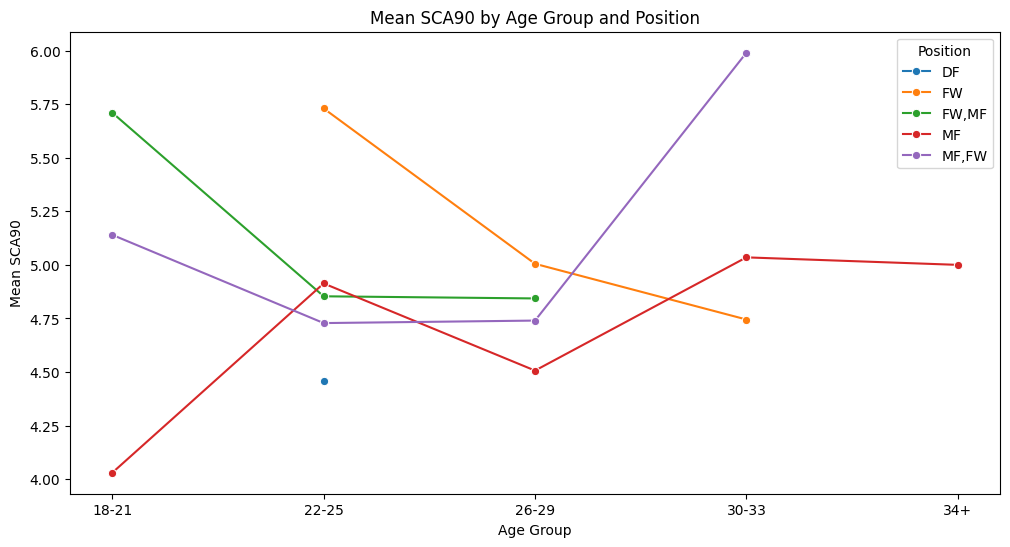

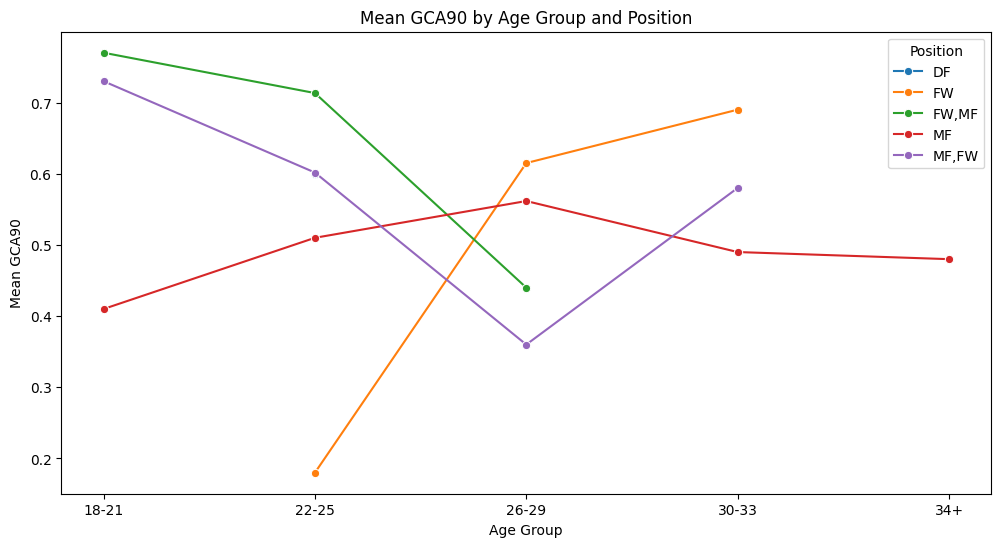

In [445]:
# --- Multi-Line Plots: Age Curves by Position ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=age_pos_summary, x='age_group', y='mean_SCA90', hue='Pos', marker='o')
plt.title('Mean SCA90 by Age Group and Position')
plt.ylabel('Mean SCA90')
plt.xlabel('Age Group')
plt.legend(title='Position')
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=age_pos_summary, x='age_group', y='mean_GCA90', hue='Pos', marker='o')
plt.title('Mean GCA90 by Age Group and Position')
plt.ylabel('Mean GCA90')
plt.xlabel('Age Group')
plt.legend(title='Position')
plt.show()

## SCA to GCA Conversion Efficiency by Age Group

- Calculate the ratio of mean GCA90 to mean SCA90 for each age group and position.
- This metric shows how efficiently shot creation actions are converted into goal creation actions as players age.

In [446]:
# --- SCA to GCA Conversion Efficiency by Age Group (Robust, filter out zero/NaN means) ---
conv_eff = age_pos_summary.copy()
# Filter out rows where mean_SCA90 is zero or NaN to avoid NaN/infinite conversion efficiency
conv_eff = conv_eff[conv_eff['mean_SCA90'].notna() & (conv_eff['mean_SCA90'] > 0)]
conv_eff['conversion_efficiency'] = conv_eff['mean_GCA90'] / conv_eff['mean_SCA90']
display(conv_eff[['age_group', 'Pos', 'conversion_efficiency']])

,age_group,Pos,conversion_efficiency
2,18-21,"FW,MF",0.134851
3,18-21,MF,0.101737
4,18-21,"MF,FW",0.142023
5,22-25,DF,0.134529
6,22-25,FW,0.031414
7,22-25,"FW,MF",0.146978
8,22-25,MF,0.103799
9,22-25,"MF,FW",0.127247
11,26-29,FW,0.122877
12,26-29,"FW,MF",0.090847


## Statistical Testing: Age Effects

- Perform ANOVA tests to determine if there are statistically significant differences in SCA90 and GCA90 across age groups.
- Significant results indicate that age has a measurable effect on creative output.

In [447]:
# --- Statistical Testing: Age Effects ---
sca90_groups = [group['SCA90'].dropna().values for name, group in shot_df.groupby('age_group')]
gca90_groups = [group['GCA90'].dropna().values for name, group in shot_df.groupby('age_group')]
sca90_anova = f_oneway(*sca90_groups)
gca90_anova = f_oneway(*gca90_groups)
print('SCA90 ANOVA: F =', sca90_anova.statistic, 'p =', sca90_anova.pvalue)
print('GCA90 ANOVA: F =', gca90_anova.statistic, 'p =', gca90_anova.pvalue)
if sca90_anova.pvalue < 0.05:
    print('Significant age effect on SCA90')
else:
    print('No significant age effect on SCA90')
if(gca90_anova.pvalue < 0.05):
    print('Significant age effect on GCA90')
else:
    print('No significant age effect on GCA90')

SCA90 ANOVA: F = 0.4885980848482452 p = 0.7440115136585874
GCA90 ANOVA: F = 0.2348961826892703 p = 0.9164767365036771
No significant age effect on SCA90
No significant age effect on GCA90


C:\Users\omara\AppData\Local\Temp\ipykernel_12300\1318204490.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\omara\AppData\Local\Temp\ipykernel_12300\1318204490.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



# Unsupervised Clustering: Player Creativity Archetypes (t-SNE Visualization)

In this section, we use unsupervised learning to identify player creativity archetypes using t-SNE for visualization instead of PCA. We cluster players based on detailed shot and goal creation breakdowns, and assign each cluster one of three archetypes: Set-piece Specialists, Take-on Creators, or Hybrid Creators.

In [448]:
# --- Prepare Data for Clustering ---
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# Define SCA and GCA breakdown columns
sca_cols = ['PassLive', 'PassDead', 'TO', 'Sh', 'Fld', 'Def']
gca_cols = ['PassLive.1', 'PassDead.1', 'TO.1', 'Sh.1', 'Fld.1', 'Def.1']

# Filter out players with missing or zero creative actions across all 12 variables
creativity_df = shot_df.dropna(subset=sca_cols + gca_cols)
creativity_df = creativity_df[(creativity_df[sca_cols + gca_cols].sum(axis=1) > 0)]

# Standardize the 12 creative action variables
scaler = StandardScaler()
X = scaler.fit_transform(creativity_df[sca_cols + gca_cols])

## Determining Optimal Number of Clusters

We use the elbow method (inertia plot) and silhouette analysis to select the optimal number of clusters for K-means.

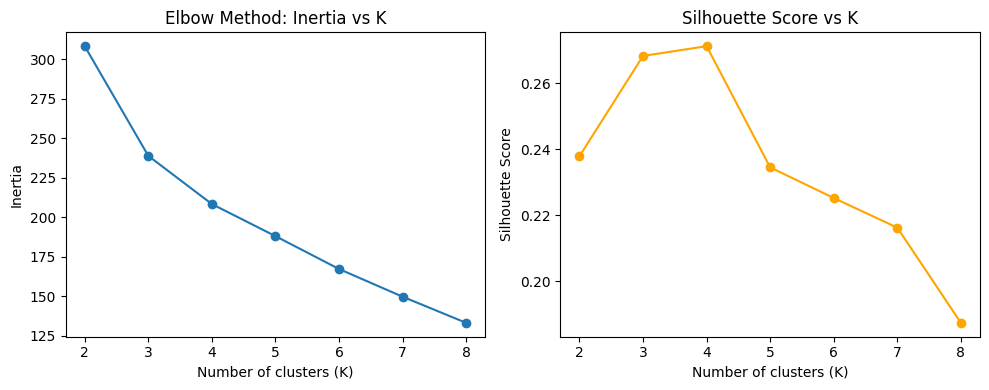

Optimal K (forced): 3


In [449]:
# --- Elbow and Silhouette Analysis ---
inertias = []
silhouettes = []
K_range = range(2, 9)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(X)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, labels))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method: Inertia vs K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(K_range, silhouettes, marker='o', color='orange')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

# Choose K with high silhouette and elbow "bend"
optimal_k = 3  # Force 3 clusters for 3 archetypes
print(f"Optimal K (forced): {optimal_k}")

## K-means Clustering and t-SNE Visualization

We apply K-means clustering with K=3 and use t-SNE to visualize clusters in 2D space.

In [450]:
# --- K-means Clustering and t-SNE (Interactive Plot with Player Names) ---
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
creativity_df['cluster'] = kmeans.fit_predict(X)

# t-SNE for 2D visualization
X_tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000).fit_transform(X)
creativity_df['TSNE1'] = X_tsne[:,0]
creativity_df['TSNE2'] = X_tsne[:,1]

# Interactive plot with player names on hover
import plotly.express as px
fig = px.scatter(
    creativity_df,
    x='TSNE1',
    y='TSNE2',
    color=creativity_df['cluster'].astype(str),
    hover_data=['Player', 'Pos', 'Age'],
    title='t-SNE Scatter Plot of Player Creativity Clusters (Interactive)',
    labels={'color': 'Cluster'},
    symbol=creativity_df['cluster'].astype(str)
)
fig.update_traces(marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')))
fig.show()

## Cluster Profiling: Mean SCA and GCA Breakdown

For each cluster, we compute the mean values of the 6 SCA and 6 GCA methods. This reveals the creative signature of each archetype.

In [451]:
# --- Cluster Profiling Table ---
cluster_profiles = creativity_df.groupby('cluster')[sca_cols + gca_cols].mean().round(2)
display(cluster_profiles)

,PassLive,PassDead,TO,Sh,Fld,Def,PassLive.1,PassDead.1,TO.1,Sh.1,Fld.1,Def.1
cluster,,,,,,,,,,,,
0,80.92,20.15,4.92,6.92,4.23,1.15,9.92,1.92,0.38,1.31,0.38,0.00
1,36.88,6.25,4.25,1.75,1.38,0.62,4.06,0.62,0.56,0.12,0.00,0.12
2,92.17,7.83,16.17,10.00,6.83,2.33,11.83,0.00,3.00,0.83,1.00,1.00


## Assigning Unique Archetype Names to Clusters

We assign each cluster a unique archetype label (Set-piece Specialists, Take-on Creators, Hybrid Creators) based on which cluster has the highest mean for each method.

In [452]:
# --- Assign Unique Archetype Names to Clusters ---
# For 3 clusters, assign each a unique archetype based on dominant mean method
archetype_labels = ['Set-piece Specialists', 'Take-on Creators', 'Hybrid Creators']

# Calculate mean PassDead and TO for each cluster
means = cluster_profiles[['PassDead', 'PassDead.1', 'TO', 'TO.1']].copy()
means['PassDead_total'] = means['PassDead'] + means['PassDead.1']
means['TO_total'] = means['TO'] + means['TO.1']

# Assign archetypes: highest PassDead_total -> Set-piece, highest TO_total -> Take-on, remaining -> Hybrid
set_piece_idx = means['PassDead_total'].idxmax()
takeon_idx = means['TO_total'].idxmax()
# Hybrid is the remaining cluster
hybrid_idx = list(set(range(optimal_k)) - {set_piece_idx, takeon_idx})[0]

cluster_archetype_map = {
    set_piece_idx: 'Set-piece Specialists',
    takeon_idx: 'Take-on Creators',
    hybrid_idx: 'Hybrid Creators'
}

cluster_profiles['Archetype'] = cluster_profiles.index.map(cluster_archetype_map)
creativity_df['Archetype'] = creativity_df['cluster'].map(cluster_archetype_map)
display(cluster_profiles[['Archetype'] + sca_cols + gca_cols])

,Archetype,PassLive,PassDead,TO,Sh,Fld,Def,PassLive.1,PassDead.1,TO.1,Sh.1,Fld.1,Def.1
cluster,,,,,,,,,,,,,
0,Set-piece Specialists,80.92,20.15,4.92,6.92,4.23,1.15,9.92,1.92,0.38,1.31,0.38,0.00
1,Hybrid Creators,36.88,6.25,4.25,1.75,1.38,0.62,4.06,0.62,0.56,0.12,0.00,0.12
2,Take-on Creators,92.17,7.83,16.17,10.00,6.83,2.33,11.83,0.00,3.00,0.83,1.00,1.00


In [453]:
# --- SCA→GCA Conversion Efficiency by Cluster ---
cluster_totals = creativity_df.groupby('cluster')[[*sca_cols, *gca_cols]].sum()
cluster_totals['SCA_total'] = cluster_totals[sca_cols].sum(axis=1)
cluster_totals['GCA_total'] = cluster_totals[gca_cols].sum(axis=1)
cluster_totals['conversion_efficiency'] = cluster_totals['GCA_total'] / cluster_totals['SCA_total']
conversion_table = cluster_totals[['SCA_total', 'GCA_total', 'conversion_efficiency']]
conversion_table['Archetype'] = cluster_profiles['Archetype']
display(conversion_table)

C:\Users\omara\AppData\Local\Temp\ipykernel_12300\3397042616.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,SCA_total,GCA_total,conversion_efficiency,Archetype
cluster,,,,
0,1538,181,0.117685,Set-piece Specialists
1,818,88,0.107579,Hybrid Creators
2,812,106,0.130542,Take-on Creators


In [454]:
# --- Player Examples by Cluster ---
example_cols = ['Player', 'Pos', 'Age'] + sca_cols + gca_cols
examples = []
for i in range(optimal_k):
    cluster_players = creativity_df[creativity_df['cluster']==i]
    sample = cluster_players[example_cols].head(3)
    sample['Archetype'] = cluster_profiles.loc[i, 'Archetype']
    examples.append(sample)
example_df = pd.concat(examples, ignore_index=True)
display(example_df)

,Player,Pos,Age,PassLive,PassDead,TO,Sh,Fld,Def,PassLive.1,PassDead.1,TO.1,Sh.1,Fld.1,Def.1,Archetype
0,Alexis Mac Allister,MF,26.0,83,24,2,6,2,3,10,3,0,2,0,0,Set-piece Specialists
1,Dominik Szoboszlai,MF,24.0,88,7,5,13,3,1,12,1,0,3,0,0,Set-piece Specialists
2,Martin Ødegaard,MF,26.0,101,13,2,5,2,0,14,2,0,1,0,0,Set-piece Specialists
3,Harvey Elliott,"MF,FW",22.0,17,3,1,0,0,0,3,0,0,0,0,0,Hybrid Creators
4,Jeremy Doku,"FW,MF",22.0,56,1,13,1,2,1,10,0,3,0,0,0,Hybrid Creators
5,Jack Grealish,"FW,MF",29.0,41,1,3,0,1,1,1,0,0,0,0,1,Hybrid Creators
6,Mohamed Salah,FW,32.0,119,2,22,14,5,2,20,0,5,2,0,0,Take-on Creators
7,Luis Díaz,FW,28.0,88,0,16,9,4,0,13,0,1,0,2,0,Take-on Creators
8,Sávio,"FW,MF",21.0,80,2,15,4,7,3,10,0,2,1,1,1,Take-on Creators
